import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    display(Markdown(string))

In [3]:
image_dir = Path('C:/Users/User/project 01/colored_images')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(3)

,Filepath,Label
0,C:\Users\User\project 01\colored_images\No_DR\...,No_DR
1,C:\Users\User\project 01\colored_images\Prolif...,Proliferate_DR
2,C:\Users\User\project 01\colored_images\No_DR\...,No_DR


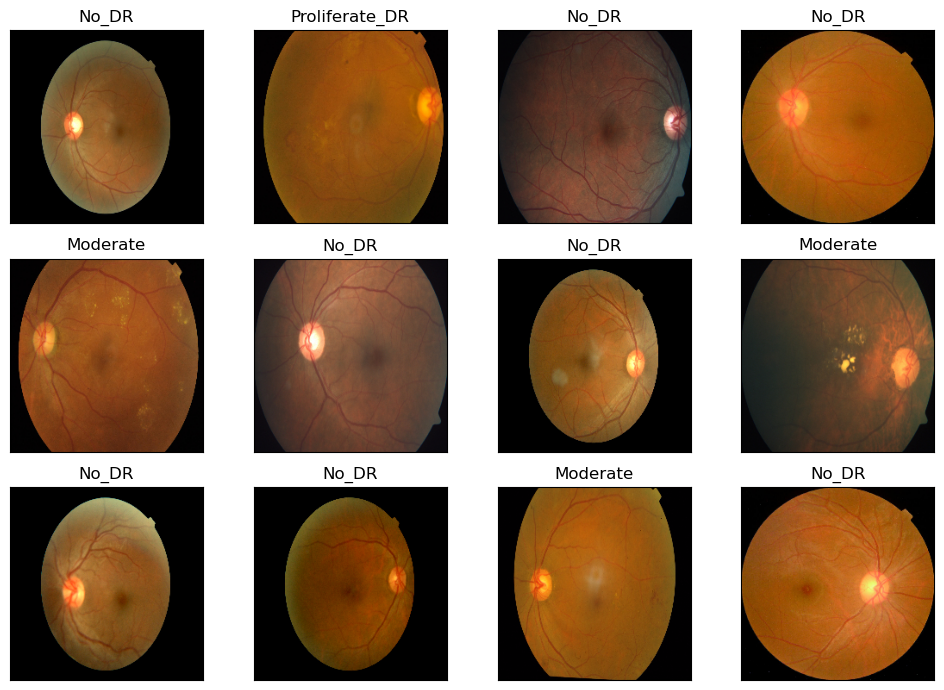

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

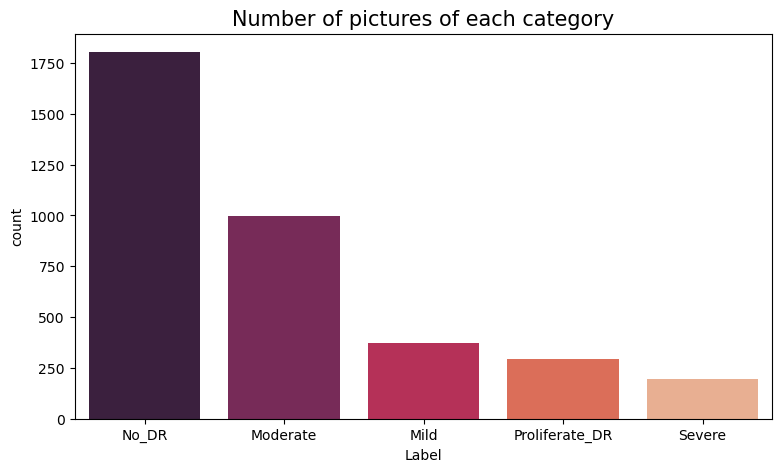

In [6]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [7]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [8]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [11]:
models = {
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
}

train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

for name, model in models.items():

    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.6207 - loss: 1.0550 - val_accuracy: 0.8024 - val_loss: 0.5844
DenseNet169          trained in 285.93 sec
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 602ms/step - accuracy: 0.6417 - loss: 1.0160 - val_accuracy: 0.8116 - val_loss: 0.5084
MobileNet            trained in 62.3 sec
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.5130 - loss: 1.2641 - val_accuracy: 0.7173 - val_loss: 0.8347
ResNet101            trained in 327.53 sec


In [12]:
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,MobileNet,0.7141,0.8116,62.30
1,DenseNet169,0.6908,0.8024,285.93
2,ResNet101,0.5779,0.7173,327.53


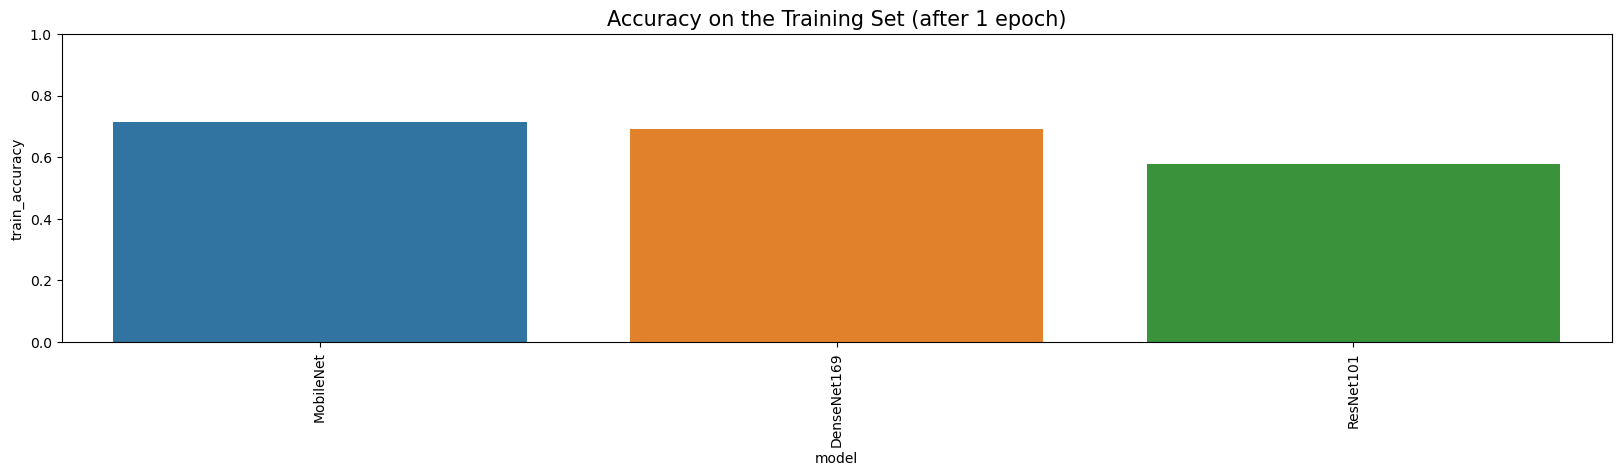

In [13]:
plt.figure(figsize = (20,4))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [14]:
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - AUC: 0.8663 - accuracy: 0.6398 - loss: 0.9995 - val_AUC: 0.9635 - val_accuracy: 0.8055 - val_loss: 0.5520
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - AUC: 0.9512 - accuracy: 0.7732 - loss: 0.6203 - val_AUC: 0.9679 - val_accuracy: 0.8085 - val_loss: 0.5134
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - AUC: 0.9528 - accuracy: 0.7777 - loss: 0.6091 - val_AUC: 0.9700 - val_accuracy: 0.8024 - val_loss: 0.4931
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - AUC: 0.9634 - accuracy: 0.7918 - loss: 0.5366 - val_AUC: 0.9700 - val_accuracy: 0.8116 - val_loss: 0.4922
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - AUC: 0.9646 - accuracy: 0.7964 - loss: 0.5289 - val_AUC: 0.9750 - val_accuracy: 0.8389 - val_loss: 0.4453
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - AUC: 0.9678 - accuracy: 0.8154 - loss: 0.4984 - val_AUC: 0.9659 - val_accuracy: 0.8207 - val_loss: 0.5214
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/

In [18]:
model.save('C:/Users/User/project 01/models/DenseNet.h5')

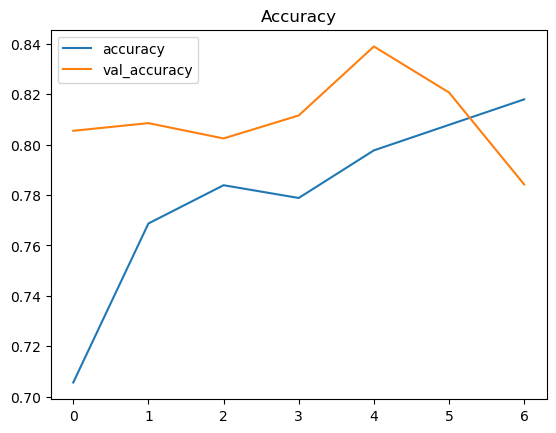

In [19]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

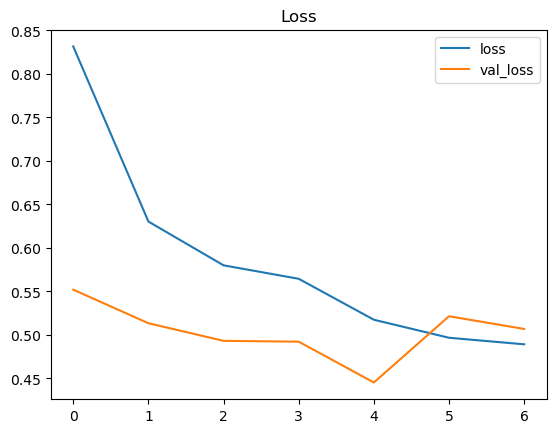

In [20]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [21]:
results = model.evaluate(test_images, verbose=0)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [22]:
printmd("Test Loss: {:.5f}".format(results[0]))
printmd("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.56075

Accuracy on the test set: 80.38%

In [23]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


In [24]:
from sklearn.metrics import classification_report

y_true = test_images.classes 
y_pred = model.predict(test_images)  

y_pred = y_pred.argmax(axis=-1)

class_labels = list(test_images.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
                precision    recall  f1-score   support

          Mild       0.88      0.53      0.66        40
      Moderate       0.68      0.79      0.73       103
         No_DR       0.94      0.99      0.97       185
Proliferate_DR       0.38      0.36      0.37        25
        Severe       0.00      0.00      0.00        14

      accuracy                           0.80       367
     macro avg       0.57      0.53      0.54       367
  weighted avg       0.78      0.80      0.79       367



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: No_dr
Confidence: 0.9973721504211426


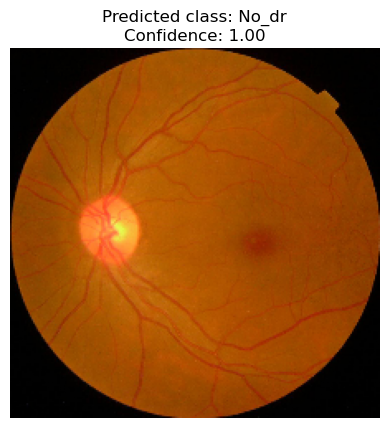

In [35]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet.h5") # Replace with the actual path to your trained model

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/No_DR/00cc2b75cddd.png"  # Replace with the actual path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Moderate
Confidence: 0.6513639092445374


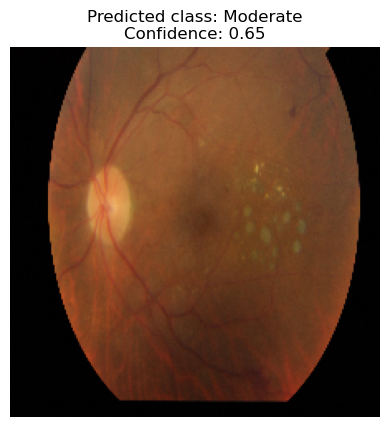

In [36]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet.h5")  # Replace with the actual path to your trained model

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/Mild/1d674e2e32e0.png"  # Replace with the actual path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Moderate
Confidence: 0.37627577781677246


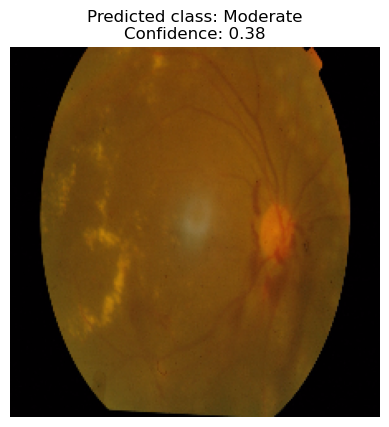

In [37]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet.h5")  # Replace with the actual path to your trained model
model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/Proliferate_DR/1b32e1d775ea.png"  # Replace with the actual path to your input image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()